# CS 579
<br>

## Clustering Words with K-Means

<br>


In [30]:
import pandas as pd
movies = pd.DataFrame([[123, ['horror', 'horror', 'romance', 'romance', 'romance']], [456, ['romance']]], columns=['movieId', 'tokens'])
movies

,movieId,tokens
0,123,"[horror, horror, romance, romance, romance]"
1,456,[romance]


tfidf(i, d) := tf(i, d) / max_k tf(k, d) * log10(N/df(i))

- df(horror) = 1
- df(romance) = 2

- tf (horror, 123) = 2
- tfidf(horror, 123) = 2 / 3 * log10(2/1)

In [41]:
d = {'a': 100, 'b': 200}
for x,y in enumerate(d):
    print(x, y)


0 b
1 a


In [50]:
for x in ['a', 'b', 'c']:
    print(x)

a
b
c


In [71]:
import networkx as nx
nx.__version__
import networkx.algorithms.community as ccc
dir(ccc)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'k_clique_communities',
 'kclique']

In [80]:
a = csr_matrix([1,2,3, 0, 0, 0, 5])
b = csr_matrix([4,5,6, 0, 0, 0, 0])
a.dot(b.T).sum()


32

In [38]:
from scipy.sparse import csr_matrix

def featurize(movies):
    dfs = Counter()
    data = []
    rows = []
    cols = []
    for tokens in movies['tokens']:
        dfs.update(set(tokens))
    vocab = {v: i for i, v in enumerate(sorted(dfs))}
    N = len(movies)
    n_cols = len(vocab)
    vectors = []
    for tokens in movies.tokens:
        tfs = Counter(tokens)
        maxtf = max(tfs.values())
        rows = [0] * len(tfs)
        cols = [vocab[t] for t in tfs]
        data = [v / maxtf * math.log10(N / dfs[t])
                for t, v in tfs.items()]
        print('tf:', [v / maxtf for t, v in tfs.items()])
        print('idf_weight:', [math.log10(N / dfs[t]) for t, v in tfs.items()])

        vectors.append(csr_matrix((data, (rows, cols)), shape=(1, n_cols)))
        
    movies['features'] = vectors
    return movies, vocab

movies, vocab = featurize(movies)
movies

Counter({'romance': 4, 'horror': 2})
tf: [0.6666666666666666, 1.0]
idf_weight: [0.0, -0.3010299956639812]
tf: [1.0]
idf_weight: [-0.3010299956639812]


,movieId,tokens,features
0,123,"[horror, horror, romance, romance, romance]","(0, 0)\t0.0\n (0, 1)\t-0.301029995664"
1,456,[romance],"(0, 1)\t-0.301029995664"


In [36]:
movies['features'][0].todense()

matrix([[ 0.20068666,  0.        ]])

# Motivation

Often, we want to know which features appear together.

- If you liked *Twilight* you might like *Nosferatu*.
- "happy" is a synonym of "glad."

Can be used to summarize a large collection of messages.

We'll use k-means to cluster together related words from Twitter.

**Caution:** This uses live Twitter data, which often contains profanity.

In [1]:
# Get some tweets containing the word 'i'.

import os
from TwitterAPI import TwitterAPI

# Read Twitter credentials from environmental variables.
api = TwitterAPI(os.environ.get('TW_CONSUMER_KEY'),
                 os.environ.get('TW_CONSUMER_SECRET'),
                 os.environ.get('TW_ACCESS_TOKEN'),
                 os.environ.get('TW_ACCESS_TOKEN_SECRET'))

# Collect 10000 tweets.
tweets = []
while True: 
    r = api.request('statuses/filter', {'track':'i',
                                      'language':'en'})
    if r.status_code != 200: # error
        break
    else:
        for item in r.get_iterator():
            tweets.append(item)
            if len(tweets) > 10000:
                break
            elif len(tweets) % 100 == 0:
                print(len(tweets))


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [2]:
print(len(tweets))

10004


In [3]:
# Each tweet is a Python dict.
print('text', tweets[0]['text'])
print('description:', tweets[0]['user']['description'])
print('name:', tweets[0]['user']['name'])
print('location:', tweets[0]['user']['location'])

text I went all the way into college and my friend didn't even need me to sing so I walked right back home lol
description: @Iovedstory: @Ieejongsks kill your own self and film it
name: klara
location: r j h² t


In [4]:
tweets = [t for t in tweets if 'text' in t]

In [5]:
len(tweets)

9236

In [6]:
# Tokenize each tweet text.
import re
tokens = []
for tweet in tweets:
    text = tweet['text'].lower()
    text = re.sub('@\S+', ' ', text)  # Remove mentions.
    text = re.sub('http\S+', ' ', text)  # Remove urls.
    tokens.append(re.findall('[A-Za-z]+', text)) # Retain words.
tokens[0]

['i',
 'went',
 'all',
 'the',
 'way',
 'into',
 'college',
 'and',
 'my',
 'friend',
 'didn',
 't',
 'even',
 'need',
 'me',
 'to',
 'sing',
 'so',
 'i',
 'walked',
 'right',
 'back',
 'home',
 'lol']

In [7]:
# Count words.
from collections import Counter

word_counts = Counter()
for tweet in tokens:
    word_counts.update(tweet)

In [8]:
# Inspect word counts.
import math

print(len(word_counts), 'unique terms')
word_counts.most_common(10)

11475 unique terms


[('i', 11098),
 ('rt', 4454),
 ('to', 3163),
 ('the', 3140),
 ('a', 2423),
 ('you', 2127),
 ('me', 2088),
 ('m', 2006),
 ('and', 1846),
 ('for', 1780)]

In [9]:
# Retain in vocabulary words occurring more than twice.
vocab = set([w for w, c in word_counts.items() if c > 2])
print('%d words occur at least three times.' % len(vocab))

3450 words occur at least thre times.


In [10]:
# Prune tokens.
newtoks = []
for i, tweet in enumerate(tokens):
    newtok = [token for token in tweet if token in vocab]
    if len(newtok) > 0:
        newtoks.append(newtok)
tokens = newtoks

In [11]:
# A sample pruned tweet.
tokens[0]

['i',
 'went',
 'all',
 'the',
 'way',
 'into',
 'college',
 'and',
 'my',
 'friend',
 'didn',
 't',
 'even',
 'need',
 'me',
 'to',
 'sing',
 'so',
 'i',
 'walked',
 'right',
 'back',
 'home',
 'lol']

In [12]:
import numpy as np
def get_contexts(tweet, i, window):
    features = []
    for j in range(np.amax([0, i-window]), i):
        features.append(tweet[j] + "@" + str(j-i))
    for j in range(i+1, min(i + window + 1, len(tweet))):
        features.append(tweet[j] + "@" + str(j-i))
    return features

get_contexts(tokens[0], i=3, window=2)

['went@-2', 'all@-1', 'way@1', 'into@2']

In [13]:
# For each term, create a context vector, indicating how often
# each word occurs to the left or right of it.
from collections import defaultdict
import numpy as np

# dict from term to context vector.
contexts = defaultdict(lambda: Counter())
window = 2
for tweet in tokens:
    for i, token in enumerate(tweet):
        features = get_contexts(tweet, i, window)
        contexts[token].update(features)
        # Optionally: ignore word order
        # contexts[token].update(tweet[:i] + tweet[i+1:])


In [14]:
contexts['i'].most_common(20)

[('m@1', 1961),
 ('rt@-1', 1605),
 ('t@2', 747),
 ('rt@-2', 558),
 ('a@2', 517),
 ('to@2', 423),
 ('can@1', 404),
 ('love@1', 401),
 ('ve@1', 389),
 ('and@-1', 379),
 ('you@2', 360),
 ('don@1', 350),
 ('have@1', 316),
 ('just@1', 309),
 ('but@-1', 306),
 ('ll@1', 280),
 ('me@-1', 272),
 ('am@1', 262),
 ('want@1', 259),
 ('voting@2', 237)]

In [15]:
# Compute the number of different contexts each term appears in.
tweet_freq = Counter()
for context in contexts.values():
    tweet_freq.update(context)
tweet_freq.most_common(5)

[('i@-1', 11023),
 ('i@-2', 10670),
 ('i@1', 8782),
 ('i@2', 6679),
 ('rt@-1', 4443)]

In [16]:
# Transform each context vector to be term freq / tweet frequency. 
# Also then normalize by length.
for term, context in contexts.items():
    for term2, frequency in context.items():
        context[term2] = frequency / (1. + math.log(tweet_freq[term2]))
    length = math.sqrt(sum([v*v for v in context.values()]))
    for term2, frequency in context.items():
        context[term2] = 1. * frequency / length
    
contexts['i'].most_common(5)

[('m@1', 0.5747594406435189),
 ('rt@-1', 0.4306190377890333),
 ('t@2', 0.2282574863791869),
 ('rt@-2', 0.14976083025975837),
 ('a@2', 0.14883646203568454)]

In [17]:
contexts['school'].most_common(10)

[('high@-1', 0.40296472175280307),
 ('home@-2', 0.2685703487067322),
 ('today@1', 0.22264391524786398),
 ('at@-1', 0.21792597834526845),
 ('from@-1', 0.20867793446926872),
 ('loan@1', 0.1891980852467466),
 ('i@2', 0.1821954509210017),
 ('to@-1', 0.17577285774306095),
 ('in@-1', 0.17165332539195124),
 ('go@-2', 0.15428605186544866)]

At this point we have a list of dictionaries, one per term, indicating the terms that co-occur (weighted by inverse tweet frequency).

Next, we have to cluster these vectors. To do this, we'll need to be able to compute the euclidean distance between two vectors.

In [18]:
# This is not efficient!
def distance(c1, c2):
    if len(c1.keys()) == 0 or len(c2.keys()) == 0:
        return 1e9
    keys = set(c1.keys()) | set(c2.keys())
    distance = 0.
    for k in keys:
        distance += (c1[k] - c2[k]) ** 2
    return math.sqrt(distance)

print(distance({'hi':10, 'bye': 5}, {'hi': 9, 'bye': 4}))
print(distance({'hi':10, 'bye': 5}, {'hi': 8, 'bye': 4}))

1.4142135623730951
2.23606797749979


In [19]:
def find_closest(term, n=5):
    terms = np.array(list(contexts.keys()))
    context = contexts[term]
    distances = []
    for term2, context2 in contexts.items():
        distances.append(distance(context, context2))
    return terms[np.argsort(distances)][:n]

find_closest('love', n=10)

array(['love', 'hope', 'm', 'am', 'swear', 'got', 'hate', 'think', 'll',
       'just'], 
      dtype='<U34')

In [20]:
nz_contexts = [t for t, context in contexts.items()
               if len(context) > 1]
contexts = dict([(term, contexts[term]) for term in nz_contexts])
print(len(nz_contexts), 'nonzero contexts')

3450 nonzero contexts


In [75]:
list(contexts.keys())[0]
list(contexts.values())[0]

Counter({'all@-2': 0.10475090614393165,
         'and@-2': 0.08863801097609053,
         'are@-2': 0.11190251371931605,
         'are@1': 0.1098551297522723,
         'are@2': 0.11112901750742091,
         'best@-1': 0.13391472366940083,
         'but@2': 0.0977293561560002,
         'cold@-1': 0.14587278593482433,
         'couple@-2': 0.18961109059083786,
         'different@-1': 0.16633117289028612,
         'doesn@2': 0.15226096778908915,
         'fake@-1': 0.17564406300573798,
         'follow@2': 0.15489023002465346,
         'for@-1': 0.08887627017462371,
         'good@-1': 0.23845350844564692,
         'hate@-2': 0.12602791503276606,
         'i@1': 0.14838795398865265,
         'i@2': 0.15252991938339272,
         'illegal@-1': 0.28661704233119895,
         'isnt@1': 0.28661704233119895,
         'it@-2': 0.09112934632877298,
         'jealous@2': 0.23392456754848406,
         'lol@1': 0.26076830616559027,
         'or@-2': 0.12154622694584051,
         'other@-2': 0.2754316

In [21]:
# Transform context dicts to a sparse vector
# for sklearn.
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
X = vec.fit_transform(contexts.values())
names = np.array(vec.get_feature_names())
print(names[:10])
print(X[0])

['a@-1' 'a@-2' 'a@1' 'a@2' 'able@-1' 'able@-2' 'able@1' 'able@2' 'about@-1'
 'about@-2']
  (0, 299)	0.104750906144
  (0, 415)	0.0886380109761
  (0, 590)	0.111902513719
  (0, 591)	0.109855129752
  (0, 592)	0.111129017507
  (0, 1174)	0.133914723669
  (0, 1702)	0.097729356156
  (0, 2303)	0.145872785935
  (0, 2631)	0.189611090591
  (0, 3157)	0.16633117289
  (0, 3296)	0.152260967789
  (0, 4123)	0.175644063006
  (0, 4511)	0.154890230025
  (0, 4549)	0.0888762701746
  (0, 5023)	0.238453508446
  (0, 5386)	0.126027915033
  (0, 5885)	0.148387953989
  (0, 5886)	0.152529919383
  (0, 5947)	0.286617042331
  (0, 6193)	0.286617042331
  (0, 6204)	0.0911293463288
  (0, 6270)	0.233924567548
  (0, 7049)	0.260768306166
  (0, 8488)	0.121546226946
  (0, 8512)	0.275431635539
  (0, 11029)	0.123109132241
  (0, 11988)	0.186014448179
  (0, 11994)	0.331368491383
  (0, 11995)	0.167711628326
  (0, 12744)	0.111290874809
  (0, 13152)	0.130384153083
  (0, 13180)	0.118102413991
  (0, 13575)	0.104469815811


In [76]:
# Which row of X is the word "love"?
love_idx = list(contexts.keys()).index('love')
print(love_idx)
# What are the context feature values for love?
print(X[love_idx])
# Print a highly ranking feature.
print(names[13566])

2024
  (0, 0)	0.00246346898702
  (0, 1)	0.00997167802523
  (0, 2)	0.00736980349692
  (0, 3)	0.0147779319712
  (0, 9)	0.0126758982305
  (0, 10)	0.00616955942916
  (0, 20)	0.00581837601041
  (0, 64)	0.0102805222537
  (0, 144)	0.00634946889276
  (0, 182)	0.0248039973276
  (0, 197)	0.00396402953612
  (0, 208)	0.00439224944827
  (0, 209)	0.00767108786181
  (0, 299)	0.00604346755965
  (0, 301)	0.0120055857526
  (0, 324)	0.00772804053261
  (0, 330)	0.00422135840345
  (0, 339)	0.00784566435158
  (0, 357)	0.00367698400711
  (0, 359)	0.00639917548149
  (0, 361)	0.00322476400301
  (0, 367)	0.00439224944827
  (0, 395)	0.0128415651254
  (0, 397)	0.00634638515225
  (0, 400)	0.00904114374447
  :	:
  (0, 13288)	0.0381099231241
  (0, 13289)	0.014678474826
  (0, 13296)	0.00906276981066
  (0, 13345)	0.0050667781115
  (0, 13364)	0.00460127639165
  (0, 13410)	0.0442223293852
  (0, 13427)	0.0191925222325
  (0, 13481)	0.00935814982797
  (0, 13503)	0.00390721774919
  (0, 13537)	0.0132871730938
  (0, 13543)	0.

In [23]:
# Let's cluster!
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans
num_clusters = 20
kmeans = KMeans(num_clusters)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [24]:
# Let's print out the top features for each mean vector.
# This is swamped by common terms
for i in range(num_clusters):
    print(i, ' '.join(names[np.argsort(kmeans.cluster_centers_[i])[::-1][:5]]))

0 the@1 i@-2 a@1 i@2 i@-1
1 a@-1 i@2 i@1 and@1 the@-1
2 i@2 i@-2 to@-2 i@1 rt@-1
3 a@-2 i@1 rt@-1 the@-2 i@-2
4 up@1 i@-2 i@-1 to@2 to@-1
5 these@-1 i@2 what@1 i@1 on@-1
6 to@-1 i@-1 i@-2 it@1 t@-1
7 i@-1 rt@-2 i@-2 t@1 a@1
8 i@-2 m@-1 i@2 i@1 m@-2
9 me@1 i@-2 you@1 to@-1 to@2
10 the@-1 i@2 in@-2 i@1 of@-2
11 t@-1 don@-2 can@-2 i@-2 i@2
12 my@-1 and@1 your@-1 i@1 i@2
13 in@1 the@2 i@-2 i@2 my@2
14 i@1 m@2 rt@-1 i@2 i@-2
15 and@1 i@2 and@-1 a@-2 i@1
16 to@1 i@-2 i@-1 be@2 the@2
17 the@-1 the@-2 this@-1 i@1 i@2
18 in@-1 on@-1 i@2 i@1 of@-1
19 of@1 the@-1 the@2 a@-1 the@-2


In [25]:
# .transform will compute the distance from each context to each cluster.
distances = kmeans.transform(X)
distances[0]

array([ 1.02761471,  1.01630968,  0.97946242,  0.98801386,  1.07498129,
        0.9964722 ,  1.04365739,  1.10110095,  1.0567092 ,  1.04074006,
        0.92325574,  1.0684381 ,  1.03479488,  1.01031291,  0.98715796,
        1.00888792,  1.06013637,  0.93636146,  0.99953703,  1.01236274])

In [26]:
# Finally, we'll print the words that are closest
# to the mean of each cluster.
terms = np.array(list(contexts.keys()))
for i in range(num_clusters):
    print(i, ' '.join(terms[np.argsort(distances[:,i])[1:10]]), '\n')

0 at of on with all doing is like through 

1 few kid picture good playlist couple rabbits great racist 

2 this not me a like so to why how 

3 me that like this you but to do my 

4 wake fucked grew messed wakes waking hurry end ended 

5 manequinchallenges chains hoes idk exactly rt and why tweets 

6 do go get say hear buy work watch find 

7 am love got just have swear ll hope think 

8 sorry dying gonna weak complaining shook voting sooooo confused 

9 give inner makes told join following brings gave text 

10 best world ocean funnie funn most uk past way 

11 believe know wait understand care judge belong handle imagine 

12 own eyes friends head mom phone contract homegirl daughter 

13 checked living stay dig moments caught supremacist keys cheetos 

14 but when yes and if cause damn because wow 

15 makeup sale puppy milk period essays married home ahead 

16 going used able ready want listened wants tried listening 

17 world way best ocean day past only election most 

18 d

Clearly, interpreting these results requires a bit of investigation.

As the number of tweets increases, we expect these clusters to become more coherent.

**How does error decrease with number of cluster?**

In [27]:
kmeans.score(X)

-3140.3778367911664

k=5 score=3254.05
k=10 score=3191.11
k=20 score=3138.28
k=50 score=3063.05
k=100 score=2984.34


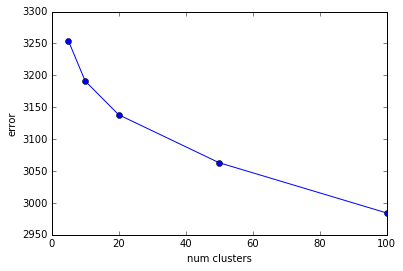

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

scores = []
num_cluster_options = [5,10,20,50,100]

for num_clusters in num_cluster_options:
    kmeans = KMeans(num_clusters, n_init=10, max_iter=10)
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print('k=%d score=%g' % (num_clusters, score))
    
plt.figure()
plt.plot(num_cluster_options, scores, 'bo-')
plt.xlabel('num clusters')
plt.ylabel('error')
plt.show()

** How does error vary by initalization? **

score=3153.41
score=3150.1
score=3142.43
score=3154.92
score=3157.75
score=3162.64
score=3148.4
score=3166.38
score=3150.52
score=3148.57


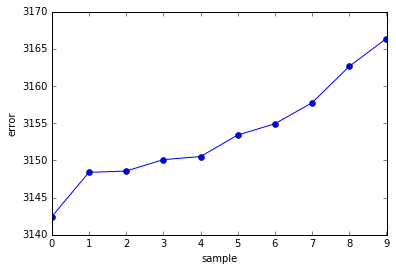

In [29]:
scores = []
for i in range(10):
    kmeans = KMeans(20, n_init=1, max_iter=100, init='random')
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print('score=%g' % (score))
     
    
plt.figure()
plt.plot(range(10), sorted(scores), 'bo-')
plt.xlabel('sample')
plt.ylabel('error')
plt.show()